In [1]:
import tensorflow as tf
print(tf.__version__)



2.20.0


Found 4999 images belonging to 2 classes.
Found 1249 images belonging to 2 classes.


C:\Users\cat15\filllevel_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1395s 9s/step - accuracy: 0.4915 - loss: 0.9610 - val_accuracy: 0.6813 - val_loss: 0.6878
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1172s 7s/step - accuracy: 0.5871 - loss: 0.9361 - val_accuracy: 0.3187 - val_loss: 0.6965
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1131s 7s/step - accuracy: 0.5549 - loss: 0.9362 - val_accuracy: 0.6813 - val_loss: 0.6900
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1182s 8s/step - accuracy: 0.6813 - loss: 0.9361 - val_accuracy: 0.6813 - val_loss: 0.6893
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1180s 8s/step - accuracy: 0.6813 - loss: 0.9361 - val_accuracy: 0.6813 - val_loss: 0.6899
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1177s 7s/step - accuracy: 0.6813 - loss: 0.9361 - val_accuracy: 0.6813 - val_loss: 0.6898
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1169s 7s/step - accuracy: 0.6813 - loss: 0.9361 - val_accuracy: 0.6813 - val_loss: 0.6905
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1147s 7s/step - accuracy: 0.6813 - loss: 0.9361 - 

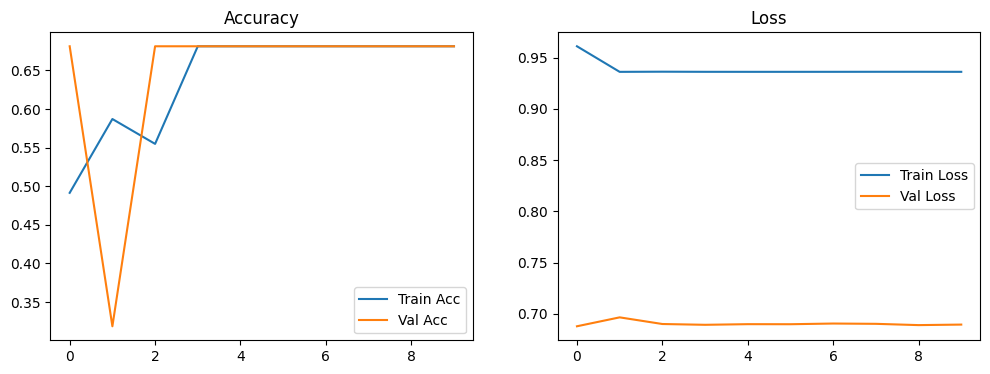

40/40 ━━━━━━━━━━━━━━━━━━━━ 352s 9s/step
Confusion Matrix:
 [[851   0]
 [398   0]]

Classification Report:
               precision    recall  f1-score   support

      Reject       0.68      1.00      0.81       851
      Accept       0.00      0.00      0.00       398

    accuracy                           0.68      1249
   macro avg       0.34      0.50      0.41      1249
weighted avg       0.46      0.68      0.55      1249



C:\Users\cat15\filllevel_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\cat15\filllevel_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\cat15\filllevel_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# -------------------------
# 1. Data Generators
# -------------------------
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,       # 80% train, 20% validation
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    r"C:\dataset1\jpg",          # 👈 full path to your dataset
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    r"C:\dataset1\jpg",          # 👈 same path
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# -------------------------
# 2. Model
# -------------------------
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False   # freeze ResNet feature extractor

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')   # binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Handle imbalance (accept has fewer samples)
class_weights = {0: 1.0, 1: 2.1}   # 0=reject, 1=accept

# -------------------------
# 3. Training
# -------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights
)

# -------------------------
# 4. Evaluation
# -------------------------
# Plot Accuracy & Loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

# Predictions
val_gen.reset()
y_true = val_gen.classes
y_pred_prob = model.predict(val_gen)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['Reject','Accept']))


Found 4999 images belonging to 2 classes.
Found 1249 images belonging to 2 classes.
Class Weights: {0: np.float64(0.7338520258367587), 1: np.float64(1.569052102950408)}


C:\Users\cat15\filllevel_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1245s 8s/step - accuracy: 0.4807 - loss: 0.7117 - val_accuracy: 0.6813 - val_loss: 0.6864
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7856s 50s/step - accuracy: 0.6535 - loss: 0.6932 - val_accuracy: 0.6813 - val_loss: 0.6910
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1121s 7s/step - accuracy: 0.6297 - loss: 0.6933 - val_accuracy: 0.6813 - val_loss: 0.6929
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1188s 7s/step - accuracy: 0.6811 - loss: 0.6932 - val_accuracy: 0.6813 - val_loss: 0.6930
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1238s 8s/step - accuracy: 0.4485 - loss: 0.6932 - val_accuracy: 0.6813 - val_loss: 0.6926
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1377s 9s/step - accuracy: 0.5633 - loss: 0.6932 - val_accuracy: 0.3187 - val_loss: 0.6936
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1331s 8s/step - accuracy: 0.5689 - loss: 0.6932 - val_accuracy: 0.3187 - val_loss: 0.6933
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1326s 8s/step - accuracy: 0.5005 - loss: 0.6932 -

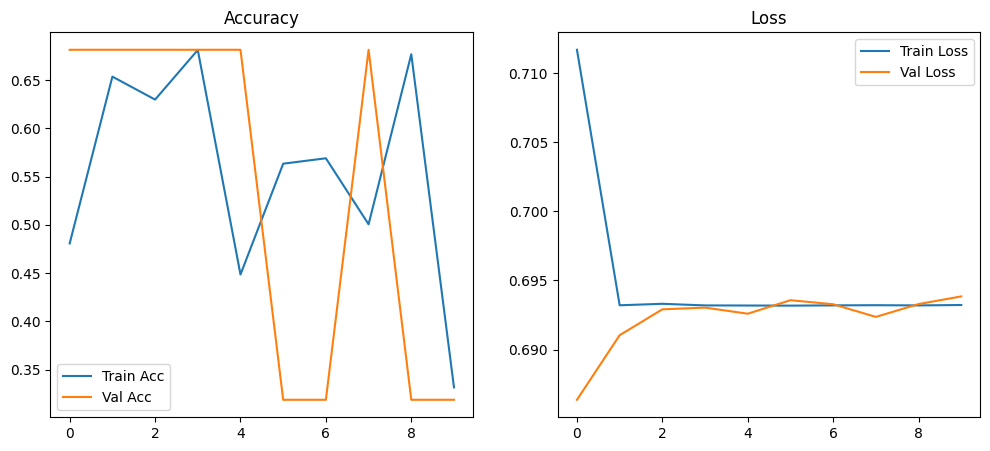

40/40 ━━━━━━━━━━━━━━━━━━━━ 412s 10s/step


C:\Users\cat15\filllevel_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\cat15\filllevel_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\cat15\filllevel_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Class labels: ['reject', 'threshold']

Confusion Matrix:
[[  0 851]
 [  0 398]]

Classification Report:
              precision    recall  f1-score   support

      reject       0.00      0.00      0.00       851
   threshold       0.32      1.00      0.48       398

    accuracy                           0.32      1249
   macro avg       0.16      0.50      0.24      1249
weighted avg       0.10      0.32      0.15      1249


✅ Model saved as resnet_filllevel_model.h5


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os

# -------------------
# Dataset path (change this 👇)
# -------------------
data_dir = r"C:\dataset1\jpg"   # your dataset folder with Accept/Reject inside

# -------------------
# Data Generators with validation split
# -------------------
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,   # 80% train, 20% validation
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

# -------------------
# Compute Class Weights
# -------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# -------------------
# Model (ResNet50)
# -------------------
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# -------------------
# Training
# -------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights
)

# -------------------
# Plot Accuracy & Loss
# -------------------
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()

# -------------------
# Confusion Matrix + Classification Report
# -------------------
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = (y_pred > 0.5).astype("int32").ravel()

y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("\nClass labels:", class_labels)

cm = confusion_matrix(y_true, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# -------------------
# Save Model
# -------------------
model.save("resnet_filllevel_model.h5")
print("\n✅ Model saved as resnet_filllevel_model.h5")


Found 4999 images belonging to 2 classes.
Found 1249 images belonging to 2 classes.
Class Weights: {0: np.float64(0.7338520258367587), 1: np.float64(1.569052102950408)}


C:\Users\cat15\filllevel_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3172s 20s/step - accuracy: 0.5363 - loss: 0.6963 - val_accuracy: 0.8295 - val_loss: 0.6367
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3082s 20s/step - accuracy: 0.5935 - loss: 0.6689 - val_accuracy: 0.7766 - val_loss: 0.6157
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3080s 20s/step - accuracy: 0.6313 - loss: 0.6472 - val_accuracy: 0.7766 - val_loss: 0.5675
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11720s 75s/step - accuracy: 0.6323 - loss: 0.6345 - val_accuracy: 0.6605 - val_loss: 0.5995
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3532s 23s/step - accuracy: 0.6613 - loss: 0.6188 - val_accuracy: 0.8295 - val_loss: 0.4972
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3284s 21s/step - accuracy: 0.6667 - loss: 0.6101 - val_accuracy: 0.7246 - val_loss: 0.5314
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6155s 39s/step - accuracy: 0.6835 - loss: 0.5953 - val_accuracy: 0.8351 - val_loss: 0.4813
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 3084s 20s/step - accuracy: 0.6927 - loss: 

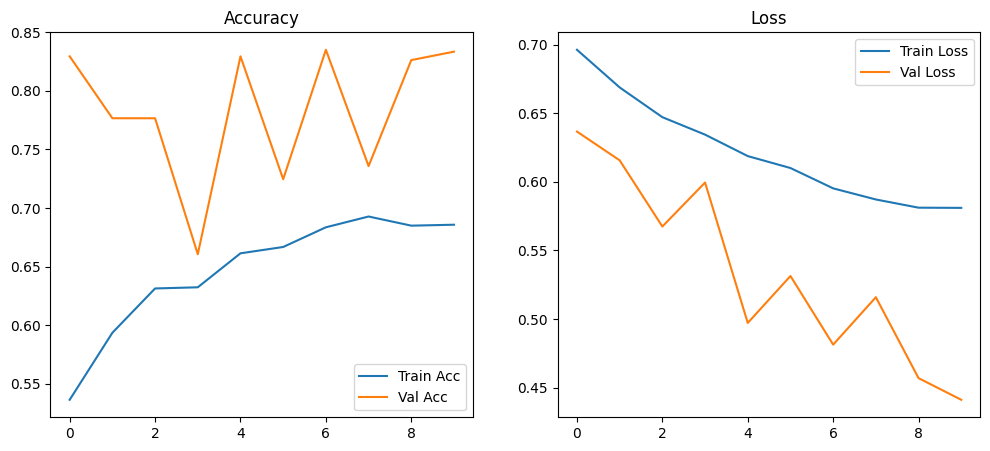

40/40 ━━━━━━━━━━━━━━━━━━━━ 711s 18s/step



Class labels: ['reject', 'threshold']

Confusion Matrix:
[[569 282]
 [256 142]]

Classification Report:
              precision    recall  f1-score   support

      reject       0.69      0.67      0.68       851
   threshold       0.33      0.36      0.35       398

    accuracy                           0.57      1249
   macro avg       0.51      0.51      0.51      1249
weighted avg       0.58      0.57      0.57      1249


✅ Model saved as vgg16_filllevel_model.h5


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os

# -------------------
# Dataset path (change this 👇)
# -------------------
data_dir = r"C:\dataset1\jpg"   # your dataset folder with Accept/Reject inside

# -------------------
# Data Generators with validation split
# -------------------
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,   # 80% train, 20% validation
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

# -------------------
# Compute Class Weights
# -------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# -------------------
# Model (VGG16)
# -------------------
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base layers

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# -------------------
# Training
# -------------------
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights
)

# -------------------
# Plot Accuracy & Loss
# -------------------
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.show()

# -------------------
# Confusion Matrix + Classification Report
# -------------------
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = (y_pred > 0.5).astype("int32").ravel()

y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print("\nClass labels:", class_labels)

cm = confusion_matrix(y_true, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# -------------------
# Save Model
# -------------------
model.save("vgg16_filllevel_model.h5")
print("\n✅ Model saved as vgg16_filllevel_model.h5")
